<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предобработка данных</a></span></li></ul></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Общий-анализ" data-toc-modified-id="Общий-анализ-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Общий анализ</a></span></li><li><span><a href="#Подбор-признаков" data-toc-modified-id="Подбор-признаков-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Подбор признаков</a></span></li></ul></li><li><span><a href="#Корреляционный-анализ" data-toc-modified-id="Корреляционный-анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Корреляционный анализ</a></span></li><li><span><a href="#Подготовка-данных-для-обучения" data-toc-modified-id="Подготовка-данных-для-обучения-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подготовка данных для обучения</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Анализ моделей</a></span><ul class="toc-item"><li><span><a href="#Обучение-деревьев-решений" data-toc-modified-id="Обучение-деревьев-решений-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Обучение деревьев решений</a></span></li><li><span><a href="#Обучение-модели-LightGBM" data-toc-modified-id="Обучение-модели-LightGBM-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Обучение модели LightGBM</a></span></li><li><span><a href="#Обучение-модели-CatBoost" data-toc-modified-id="Обучение-модели-CatBoost-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Обучение модели CatBoost</a></span></li></ul></li><li><span><a href="#Анализ-признаков" data-toc-modified-id="Анализ-признаков-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Анализ признаков</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Мастерская №2

**Описание проекта:** Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

**Цель исследования:** 
Предсказать вероятность покупки в течение 90 дней.

**Ход исследования:**

- Изучить данные;
- Разработать полезные признаки;
- Создать модель для классификации пользователей;
- Улучшить модель и максимизировать метрику roc_auc;
- Выполнить тестирование.

**Общий вывод:** резюмирование полуенных результатов, формулировка ключевых выводов и результатов.

In [1]:
!pip install catboost -q
!pip install lightgbm -q
!pip install scikit-learn==1.5.1 -q
!pip install matplotlib==3.7.3 -q
!pip install -q --upgrade numba
!pip install phik -q
!pip install shap -q
!pip freeze > requirements.txt -q

In [2]:
# импорты из стандартной библиотеки.
import warnings

# импорты сторонних библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import shap
from phik import phik_matrix

# импорты модулей текущего проекта
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler
)


# настройки
warnings.filterwarnings("ignore", category=FutureWarning)

# константы
RANDOM_STATE = 42
TEST_SIZE = 0.2

In [3]:
def data_info(data, data_name):
    """Выводит информацию о столбцах таблицы для предобработки данных: 
    информация о столбцах таблицы, кол-во незаполненных значений в полях, число дубликатов
    Args:
        data - датасет
        data_name - наименование датасета
    Returns:
        нет возвращаемых данных
    Raises:
        нет обработки ошибок
    """
    print("Информация о столбцах таблицы ", data_name)
    display(data.info())
    print("Количество незаполненных значений в полях:")
    print(data.isna().sum())
    dupl = data.duplicated().sum()
    print("Количество дубликатов:", dupl)

In [4]:
def col_info(data, list_cols):
    """Информация по количеству уникальных значений в столбцах таблицы
    Args:
        data - датасет
        list_cols - список столбцов для вывода уникальных значений
    Returns:
        нет возвращаемых данных
    Raises:
        нет обработки ошибок
    """
    for col in list_cols:
        print('----------------------')
        print(data[col].value_counts().sort_index()) 

In [5]:
def numeric_exploration(data, lst_cols):
    """Выполняет построение гистограммы и ящика с усами
    Args:
        data - датасет
        lst_cols - список столбцов с числовыми значениями для обработки
    Returns:
        нет возвращаемых данных
    Raises:
        нет обработки ошибок
    """
    for col in lst_cols:
        print('Статистическая информация по столбцу:', col)
        print(data[col].describe()) 
        
        fig, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw=dict(width_ratios=[4, 3]))
        hpl = sns.histplot(data[col], kde=False, bins=30, ax=axs[0])
        hpl.axes.set_title('Гистограмма по признаку ' + col, fontsize=16)
        hpl.set_xlabel(col, fontsize=14)
        hpl.set_ylabel("Частота", fontsize=14)         
        hpl.grid(True)
        
        bpl = sns.boxplot(data=data, orient='h', x=col, ax=axs[1])
        bpl.axes.set_title('Ящик с усами для признака ' + col, fontsize=16)
        bpl.set_xlabel(col, fontsize=14)
        #bpl.set_ylabel("Значения", fontsize=14)         
        bpl.grid(True)
        fig.tight_layout()
        plt.show()

In [6]:
def category_exploration(data, lst_cols):
    """Выполняет построение диаграммы
    Args:
        data - датасет
        lst_cols - список столбцов с категориальными (непорядковыми) значениями для обработки
    Returns:
        нет возвращаемых данных
    Raises:
        нет обработки ошибок
    """
    if (len(lst_cols) == 1):
        cnt_col = "client_id"
    else: 
        cnt_col = lst_cols[-1]
    for col in lst_cols:
        print(f'Число уникальных значений признака {col} составляет {len(data[col].unique())}')
        a = data.groupby(col).agg({cnt_col:'count'}).reset_index()
        a.columns = [col, 'количество_записей']
        a['Percentage'] = a['количество_записей'] / a['количество_записей'].sum()*100
        a = a.sort_values(['количество_записей'],ascending=False).reset_index(drop=True)        
        a = a.loc[:20,]
        print(a)
        
        fig, ax = plt.subplots(1, figsize=(10, 4))
        sns.barplot(x=col, y='количество_записей', data=a, ax=ax)
        fig.tight_layout()
        plt.show()
        #a.plot(kind='bar', xlabel=col, ylabel='Количество автомобилей', x=col, y='количество_записей',
        #                      title='Количество автомобилей в разрезе признака ' + col, figsize=(8,8))
        cnt_col = col

In [7]:
def discrete_exploration(data, lst_cols):
    """Выполняет построение диаграммы
    Args:
        data - датасет
        lst_cols - список столбцов с категориальными (порядковыми) значениями для обработки
    Returns:
        нет возвращаемых данных
    Raises:
        нет обработки ошибок
    """
    if (len(lst_cols) == 1):
        cnt_col = "client_id"
    else: 
        cnt_col = lst_cols[-1]
    for col in lst_cols:
        a = data.groupby(col).agg({cnt_col:'count'}).reset_index()
        a.columns = [col, 'количество_записей']
        a['Percentage'] = a['количество_записей'] / a['количество_записей'].sum()*100
        a = a.sort_values(['количество_записей'],ascending=False).reset_index(drop=True)        
        a = a.loc[:20,]
        print(a)
        
        fig, ax = plt.subplots(1, figsize=(10, 4))
        sns.countplot(x=col, data=data, ax=ax)
        fig.tight_layout()
        plt.show()
        cnt_col = col

In [8]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [9]:
def make_rating(df, df_train, df_test):
    cat = 'category_3'
    train_ = df_train.merge(df.loc[:, ['client_id', cat, 'date']], on='client_id', how='inner')
    rating = train_[cat].value_counts().sort_index()
    
    train_['rating'] = train_[cat].apply(lambda x: rating[x]).astype(int)
    last_cat_train = (train_
            .pivot_table(index=['client_id','rating'], values='date', aggfunc='max')
            .reset_index()
            .pivot_table(index=['client_id'], values='rating', aggfunc='max')
            .reset_index())
    df_train = df_train.merge(last_cat_train.loc[:,['client_id','rating']], on='client_id', how='left')
    
    test_ = df_test.merge(df.loc[:, ['client_id', cat, 'date']], on='client_id', how='inner')
    test_['rating'] = test_[cat].apply(lambda x: rating[x] if any(x == rating.index) else 0).astype(int)
    last_cat_test = (test_
            .pivot_table(index=['client_id','rating'], values='date', aggfunc='max')
            .reset_index()
            .pivot_table(index=['client_id'], values='rating', aggfunc='max')
            .reset_index())
    df_test = df_test.merge(last_cat_test.loc[:,['client_id','rating']], on='client_id', how='left')
    
    return df_train, df_test

In [10]:
def present_result(df_res, X_test, y_test):
    df_res = df_res.sort_values(by='roc_auc', ascending=False).reset_index(drop=True)
    print('Результаты лучших моделей:')
    display(df_res)
    print('Лучшая модель из лучших:')
    display(df_res.loc[0,'best_estimator'])
    y_test_pred = df_res.loc[0,'best_estimator'].predict(X_test)
    print(f'Метрика Roc_auc на тестовой выборке для самой лучшей модели: {roc_auc_score(y_test, y_test_pred)}')
    return df_res

In [11]:
def best_among_class_model(pipe_final, param_grid, X_train, y_train):
    grid = GridSearchCV(
            pipe_final, 
            param_grid=param_grid, 
            cv=10, 
            scoring='roc_auc', 
            n_jobs = -1,
            error_score='raise'
    )
    grid.fit(X_train, y_train)
    df_res = pd.DataFrame(grid.cv_results_).sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)
    return [grid.best_estimator_,grid.best_estimator_.named_steps['models'], grid.best_score_,
            df_res.loc[0,'mean_fit_time'], df_res.loc[0,'mean_score_time']]

In [12]:
def change_type_int(df):
    if 'rating' in df.columns:
        df['rating'] = df['rating'].astype(int)
    return df

In [13]:
def change_type_cat(df):
    if 'rating' in df.columns:
        df['rating'] = df['rating'].astype('category')
    return df

In [14]:
def change_type_obj(df):
    if 'rating' in df.columns:
        df['rating'] = df['rating'].astype(int)
    return df

## Подготовка данных

### Загрузка данных

In [15]:
df_mess = pd.read_csv('apparel-messages.csv',
                         parse_dates=['date', 'created_at'])
df_purch = pd.read_csv('apparel-purchases.csv',
                         parse_dates=['date'])
df_tar = pd.read_csv('apparel-target_binary.csv')

In [16]:
df_mess.head(10)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06


In [17]:
df_purch.head(10)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3
6,1515915625490211585,1,1699.0,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283
7,1515915625490739153,1,1999.0,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b
8,1515915625491478747,1,999.0,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59
9,1515915625491651493,1,699.0,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2


In [18]:
df_tar.head(10)

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0
5,1515915625468061514,0
6,1515915625468061877,0
7,1515915625468061975,0
8,1515915625468061994,0
9,1515915625468062158,0


Загружены данные об истории покупателей, истории рекламных рассылок и целевого признака.

### Предобработка данных

In [19]:
data_info(df_purch, "История покупок")

Информация о столбцах таблицы  История покупок
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


None

Количество незаполненных значений в полях:
client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64
Количество дубликатов: 73020


In [20]:
col_info(df_purch, ["quantity", "category_ids", "date"])

----------------------
quantity
1     201323
2        751
3         94
4         12
5          3
6          5
7          1
8          1
9          2
10         4
13         1
15         3
18         1
20         3
25         2
30         2
Name: count, dtype: int64
----------------------
category_ids
['1', '22', '50', '685']               2
['1', '8', '280', '710']               1
['2', '17', '107', '453']            100
['2', '17', '137', '469']            317
['2', '17', '171', '475']            160
                                    ... 
['6060', '6059', '6071', '6292']      23
['6060', '6059', '6072', '1853']      72
['6060', '6059', '6076', '1153']     139
[None]                              1264
[]                                  5579
Name: count, Length: 933, dtype: int64
----------------------
date
2022-05-16     36
2022-05-17    487
2022-05-18    279
2022-05-19    166
2022-05-20    818
             ... 
2024-02-12    310
2024-02-13    392
2024-02-14    459
2024-02-15    127


In [21]:
df_purch = df_purch.drop_duplicates()
df_purch.duplicated().sum()

0

Удалим явные дубликаты в данных, хотя в истории покупок дубликаты занимают около 30% данных. Это сделано для того, чтобы перейти целевую метрику 0.7 (при оставлении дубликатов целевая метрика лучшей модели равна 0.69).

In [22]:
#подсчет числа элементов в списке категорий.
ser_cat = df_purch['category_ids'].str.count(',')
ser_cat.value_counts()
#категорий не более 5, в принципе можно разместить отдельные столбцы под категории

category_ids
3    124747
0      3360
2       736
4       345
Name: count, dtype: int64

In [23]:
df_purch['category_ids'] = df_purch['category_ids'].apply(ast.literal_eval) 

In [24]:
for pos in range(0,5):
    df_purch['category_' + str(pos)] =\
    df_purch.apply(lambda x: x['category_ids'][pos] if (~(x['category_ids'] is np.nan) & (len(x['category_ids']) > pos)) else 0,
                   axis=1)
    df_purch['category_' + str(pos)] = df_purch['category_' + str(pos)].fillna(0)
    df_purch['category_' + str(pos)] = df_purch['category_' + str(pos)].astype(int)

In [25]:
df_purch.head()

,client_id,quantity,price,category_ids,date,message_id,category_0,category_1,category_2,category_3,category_4
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,0
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,0
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,57,431,0
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,244,432,0
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,49,413,0


In [26]:
col_info(df_purch, ['category_0', 'category_1', 'category_2', 'category_3', 'category_4'])

----------------------
category_0
0        3360
1           3
2       17995
3           6
4       73428
5           1
5562    29148
5963      789
6060     4458
Name: count, dtype: int64
----------------------
category_1
0        3360
8           1
10          1
12          4
14          2
17       1959
18      16036
22          2
27       7223
28      53564
29       3280
30         59
31       5562
44        705
1822     2476
5536     2997
5558      273
5589     4007
5597     1199
5599      201
5630     6543
5631     5494
5632     1207
5633     3626
5634     2767
5683      776
5697       58
5837      559
5959      789
6057      619
6058     3358
6059      481
Name: count, dtype: int64
----------------------
category_2
0       3360
38      1085
44       272
49      1652
50         2
        ... 
6244      73
6245      79
6265      18
6266      34
6309      14
Name: count, Length: 292, dtype: int64
----------------------
category_3
0       4096
387      345
413     1299
415     2735
416 

In [27]:
data_info(df_mess, "История рекламных рассылок")

Информация о столбцах таблицы  История рекламных рассылок
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


None

Количество незаполненных значений в полях:
bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64
Количество дубликатов: 48610


In [28]:
col_info(df_mess, ['event', 'channel'])

----------------------
event
click           496339
close                1
complain           528
hard_bounce      19903
hbq_spam           823
open           3085820
purchase         64679
send           9058196
soft_bounce      10583
subscribe           85
unsubscribe       2841
Name: count, dtype: int64
----------------------
channel
email          5227642
mobile_push    7512156
Name: count, dtype: int64


Удалим явные дубликаты в данных, т.к. в истории сообщений дубликаты занимают около 3% данных.

In [29]:
df_mess = df_mess.drop_duplicates()
df_mess.duplicated().sum()

0

In [30]:
data_info(df_tar, "Таблица с целевым признаком")

Информация о столбцах таблицы  Таблица с целевым признаком
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None

Количество незаполненных значений в полях:
client_id    0
target       0
dtype: int64
Количество дубликатов: 0


In [31]:
col_info(df_tar, ['target'])

----------------------
target
0    48888
1      961
Name: count, dtype: int64


**Выводы по 1 разделу:** Выполнена предобработка данных: 
- установлены соответствующие типы данных;
- удалены дубликаты, в том числе из истории покупок, т.к. если этого не сделать лучшая модель дает метрику 0.69;
- значение категорий в истории покупок разбито на 4 отдельных столбца.

## Исследовательский анализ данных

### Общий анализ

In [32]:
purch_num_cols = ['price']

Статистическая информация по столбцу: price
count    129188.000000
mean       1264.532766
std        1375.016339
min           1.000000
25%         399.000000
50%         999.000000
75%        1750.000000
max       85499.000000
Name: price, dtype: float64


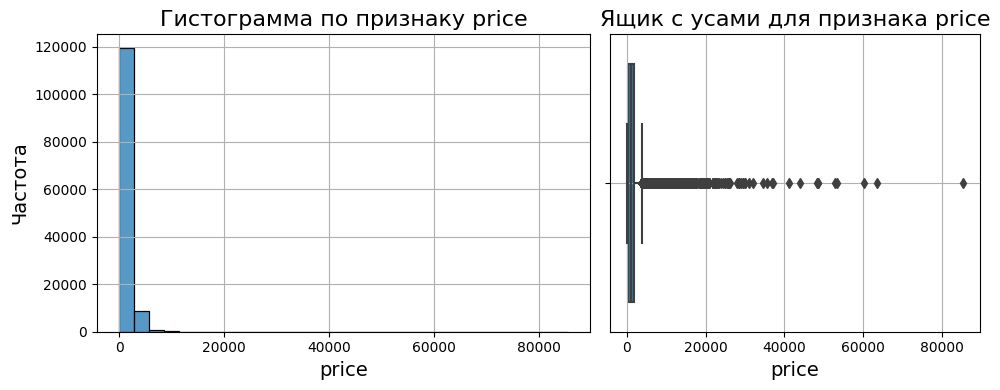

In [33]:
numeric_exploration(df_purch, purch_num_cols)

In [34]:
df_purch[df_purch['price'] > 40000]

,client_id,quantity,price,category_ids,date,message_id,category_0,category_1,category_2,category_3,category_4
6018,1515915625692218402,1,48499.0,"[4, 29, 312, 1576]",2022-06-01,1515915625489907961-4679-62972222453b3,4,29,312,1576,0
138818,1515915625971673322,1,53499.0,"[4, 29, 310, 1577]",2023-06-13,1515915625971673322-13342-648873c693815,4,29,310,1577,0
166576,1515915625776653984,1,63499.0,"[4, 29, 310, 1577]",2023-08-26,1515915625776653984-13719-64e85f9332bc8,4,29,310,1577,0
166578,1515915625776653984,1,60200.0,"[4, 29, 310, 1577]",2023-08-26,1515915625776653984-13719-64e85f9332bc8,4,29,310,1577,0
171434,1515915625959777467,1,43999.0,"[4, 29, 313, 1574]",2023-09-27,1515915625959777467-13868-6513cbb257da6,4,29,313,1574,0
171435,1515915625959777467,1,48499.0,"[4, 29, 313, 1574]",2023-09-27,1515915625959777467-13868-6513cbb257da6,4,29,313,1574,0
171436,1515915625959777467,1,52999.0,"[4, 29, 313, 1574]",2023-09-27,1515915625959777467-13868-6513cbb257da6,4,29,313,1574,0
183759,1515915625660769903,1,41160.0,"[4, 29, 313, 1574]",2023-12-21,1515915625660769903-14320-657c02501844d,4,29,313,1574,0
186736,1515915625553309277,1,85499.0,"[4, 29, 313, 1574]",2023-12-24,1515915625553309277-14352-6585585d7a711,4,29,313,1574,0
198462,1515915625995288129,1,48299.0,"[4, 29, 310, 1577]",2024-01-31,1515915625995288129-14553-65b65deea7556,4,29,310,1577,0


In [35]:
df_purch = df_purch[df_purch['price'] <= 40000]

Статистическая информация по столбцу: price
count    129178.000000
mean       1260.402754
std        1288.033633
min           1.000000
25%         399.000000
50%         999.000000
75%        1750.000000
max       37240.000000
Name: price, dtype: float64


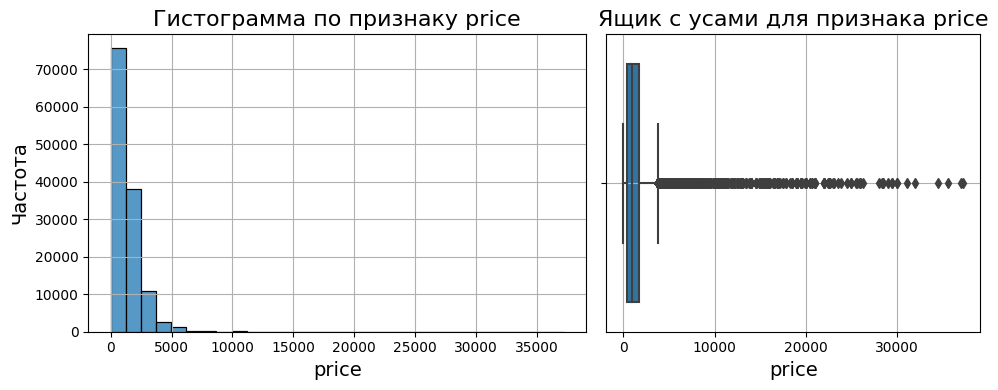

In [36]:
numeric_exploration(df_purch, purch_num_cols)

Срезали 10 вбросов.

In [37]:
purch_cat_cols = ['category_0', 'category_1', 'category_2', 'category_3', 'category_4']

Число уникальных значений признака category_0 составляет 9
   category_0  количество_записей  Percentage
0           4               73418   56.834755
1        5562               29148   22.564214
2           2               17995   13.930391
3        6060                4458    3.451052
4           0                3360    2.601062
5        5963                 789    0.610785
6           3                   6    0.004645
7           1                   3    0.002322
8           5                   1    0.000774


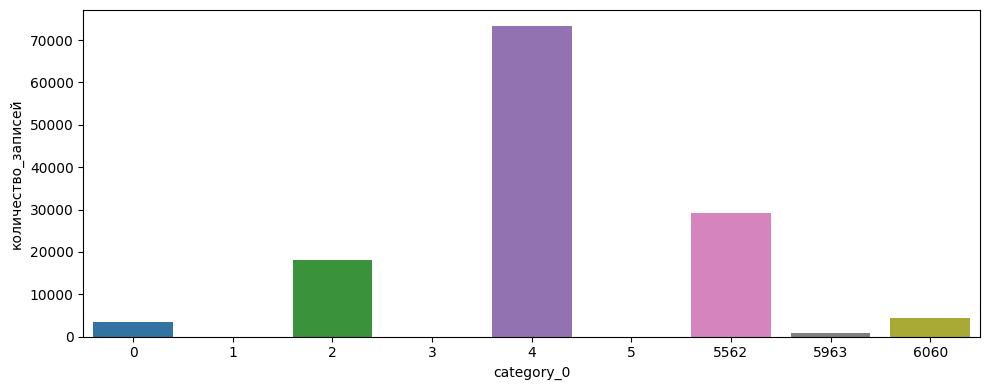

Число уникальных значений признака category_1 составляет 32
    category_1  количество_записей  Percentage
0           28               53564   41.465265
1           18               16036   12.413879
2           27                7223    5.591509
3         5630                6543    5.065104
4           31                5562    4.305687
5         5631                5494    4.253046
6         5589                4007    3.101921
7         5633                3626    2.806980
8            0                3360    2.601062
9         6058                3358    2.599514
10          29                3270    2.531391
11        5536                2997    2.320054
12        5634                2767    2.142006
13        1822                2476    1.916735
14          17                1959    1.516512
15        5632                1207    0.934370
16        5597                1199    0.928177
17        5959                 789    0.610785
18        5683                 776    0.600721


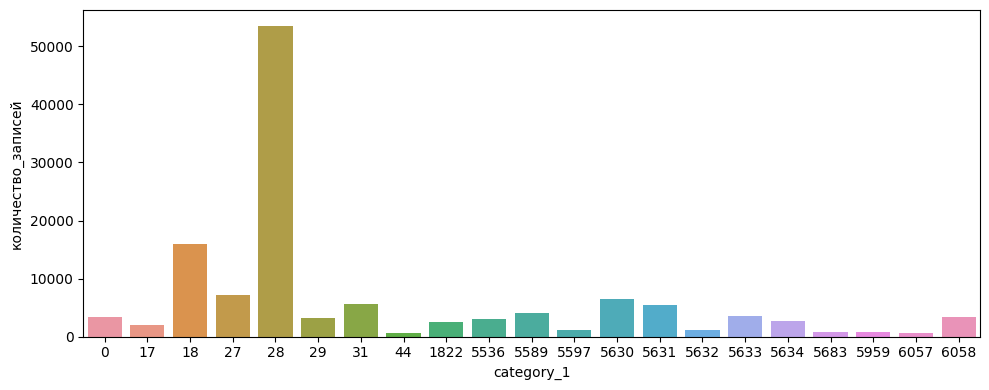

Число уникальных значений признака category_2 составляет 292
    category_2  количество_записей  Percentage
0           57                6191    4.792612
1          275                5776    4.471350
2          260                5570    4.311880
3           62                5326    4.122993
4          244                4835    3.742897
5          258                4665    3.611296
6          290                3541    2.741179
7            0                3360    2.601062
8          213                3185    2.465590
9          124                2812    2.176841
10         249                2517    1.948474
11         324                2485    1.923702
12         212                2181    1.688368
13         343                2108    1.631857
14          61                1940    1.501804
15         326                1867    1.445293
16          58                1798    1.391878
17          49                1652    1.278856
18         146                1580    1.223118

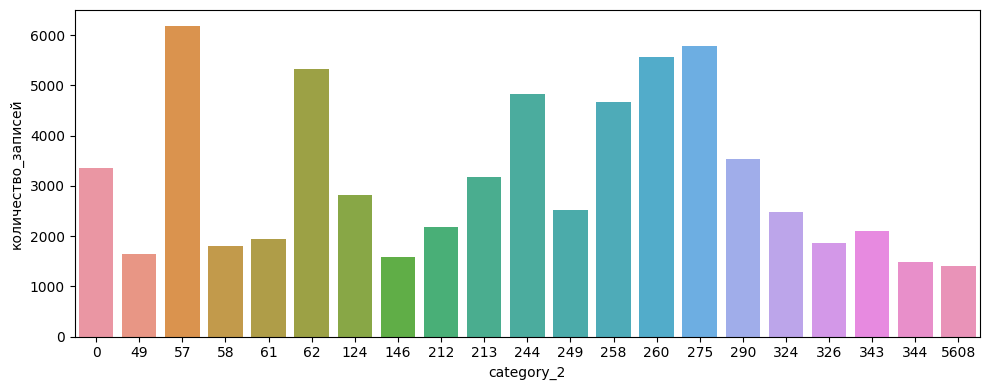

Число уникальных значений признака category_3 составляет 839
    category_3  количество_записей  Percentage
0          431                6191    4.792612
1          432                4835    3.742897
2          420                4421    3.422409
3            0                4096    3.170819
4          421                3309    2.561582
5          441                3175    2.457849
6          657                2841    2.199291
7          415                2735    2.117234
8          656                2485    1.923702
9          673                2322    1.797520
10         422                2080    1.610181
11         436                2075    1.606311
12         425                2037    1.576894
13         505                1867    1.445293
14         445                1487    1.151125
15         616                1399    1.083002
16         548                1378    1.066745
17         661                1316    1.018749
18         413                1299    1.005589

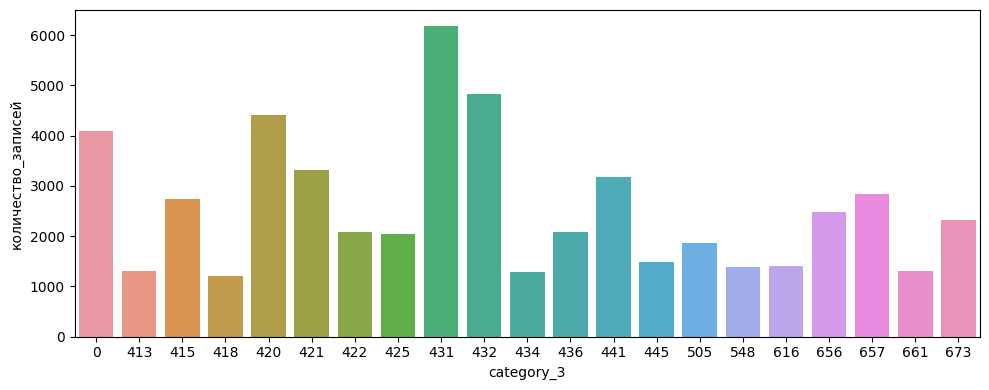

Число уникальных значений признака category_4 составляет 2
   category_4  количество_записей  Percentage
0           0              128833   99.732927
1         467                 345    0.267073


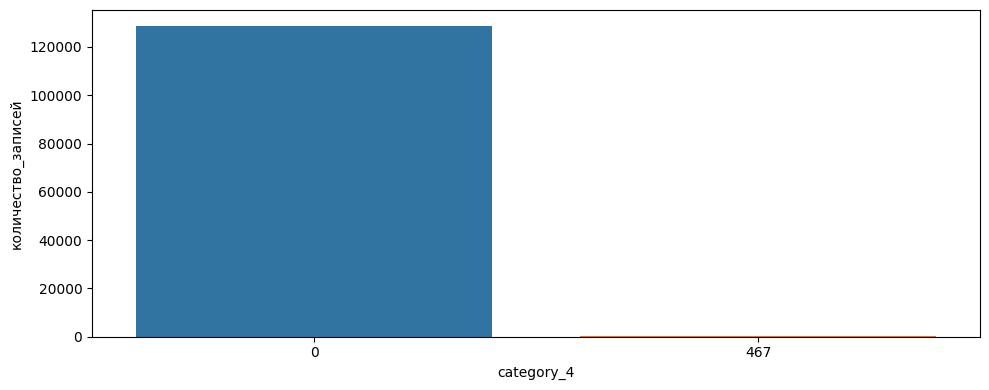

In [38]:
category_exploration(df_purch, purch_cat_cols)

Срезы по созданным признакам категорий делать не будем, т.к. они понадобятся для дальнейшего анализа.

In [39]:
purch_ord_cols = ['quantity']

    quantity  количество_записей  Percentage
0          1              128342   99.352831
1          2                 714    0.552726
2          3                  86    0.066575
3          4                  12    0.009290
4          6                   4    0.003097
5          5                   3    0.002322
6         10                   3    0.002322
7         15                   3    0.002322
8         20                   2    0.001548
9         25                   2    0.001548
10        30                   2    0.001548
11         7                   1    0.000774
12         8                   1    0.000774
13         9                   1    0.000774
14        13                   1    0.000774
15        18                   1    0.000774


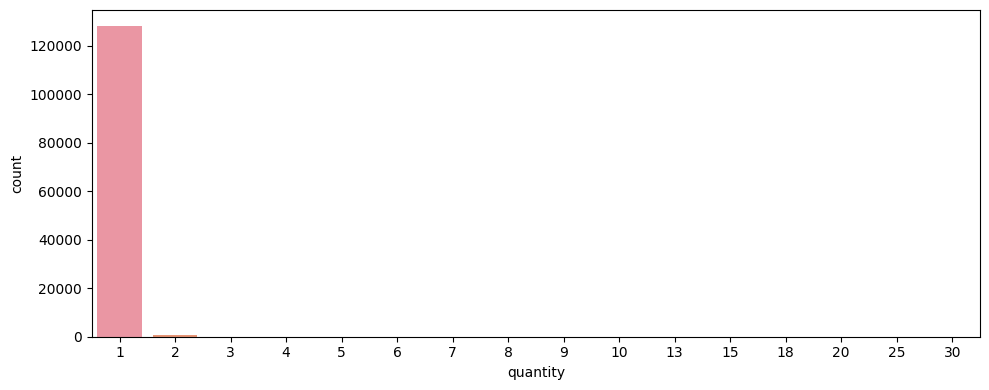

In [40]:
discrete_exploration(df_purch, purch_ord_cols)

In [41]:
df_purch[df_purch['quantity'] > 10]

,client_id,quantity,price,category_ids,date,message_id,category_0,category_1,category_2,category_3,category_4
23702,1515915625540239255,25,2.0,"[5562, 5597, 5691, 889]",2022-07-14,1515915625540239255-5403-62ce6dd7d68a1,5562,5597,5691,889,0
23866,1515915625740853027,20,2.0,"[5562, 5597, 5691, 889]",2022-07-14,1515915625491240655-5403-62ce6db70596e,5562,5597,5691,889,0
26557,1515915625509511395,25,4.0,"[5562, 5597, 5691, 889]",2022-07-27,1515915625509511395-5623-62df9127ce354,5562,5597,5691,889,0
26558,1515915625509511395,13,4.0,"[5562, 5597, 5691, 889]",2022-07-27,1515915625509511395-5623-62df9127ce354,5562,5597,5691,889,0
37005,1515915625548883766,30,2.0,"[5562, 5597, 5691, 889]",2022-09-06,1515915625548883766-6283-6316e248bbbf9,5562,5597,5691,889,0
67945,1515915625892804258,15,3.0,"[4, 1822, 1821, 1613]",2022-12-16,1515915625566723180-8722-639c17d50f223,4,1822,1821,1613,0
85277,1515915625776529170,18,29.0,"[5562, 5589, 5624, 1697]",2023-02-17,1515915625776529170-10179-63edf893515eb,5562,5589,5624,1697,0
126157,1515915625629378288,15,29.0,"[5562, 5589, 5588, 1782]",2023-06-01,1515915625629378288-13004-64785cb507acf,5562,5589,5588,1782,0
158373,1515915625594593699,30,2.0,"[5562, 5597, 5691, 889]",2023-07-12,1515915625468268596-13482-64ae724c9316b,5562,5597,5691,889,0
163556,1515915625491601434,20,19.0,"[5562, 5597, 5691, 889]",2023-08-13,1515915625889086291-13640-64d5f72d3db0e,5562,5597,5691,889,0


In [42]:
df_purch = df_purch[df_purch['quantity'] <= 10]

Срезали 11 вбросов.

In [43]:
mess_cat_cols = ['event', 'channel']

Число уникальных значений признака event составляет 11
          event  количество_записей  Percentage
0          send             9058174   71.373728
1          open             3052481   24.051972
2         click              483326    3.808359
3      purchase               62593    0.493200
4   hard_bounce               19763    0.155722
5   soft_bounce               10582    0.083381
6   unsubscribe                2833    0.022323
7      hbq_spam                 823    0.006485
8      complain                 527    0.004152
9     subscribe                  85    0.000670
10        close                   1    0.000008


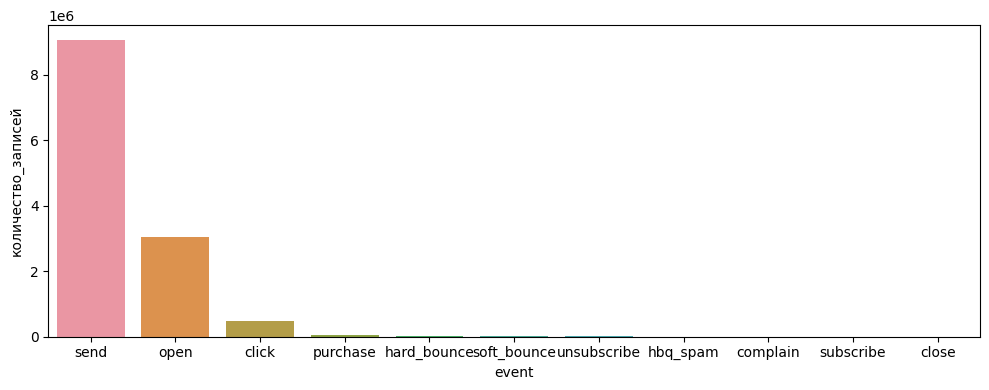

Число уникальных значений признака channel составляет 2
       channel  количество_записей  Percentage
0  mobile_push             7470472   58.863457
1        email             5220716   41.136543


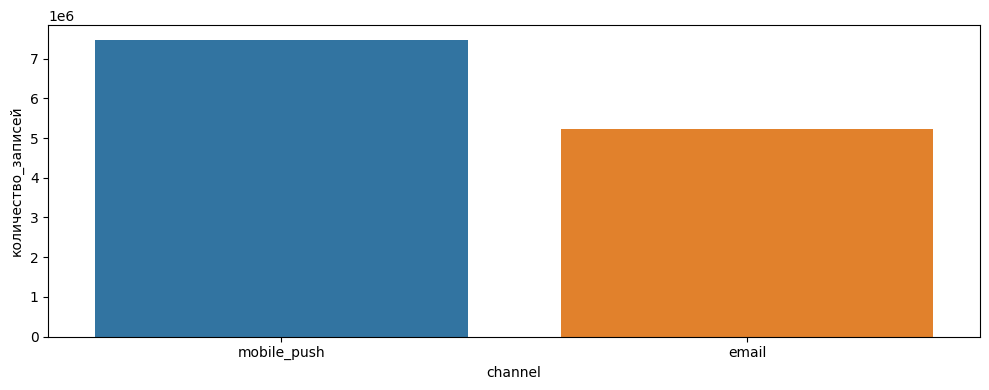

In [44]:
category_exploration(df_mess, mess_cat_cols)

Срезы по имеющимся признакам категорий делать не будем, т.к. они понадобятся для дальнейшего анализа.

In [45]:
tar_cat_cols = ['target']

Число уникальных значений признака target составляет 2
   target  количество_записей  Percentage
0       0               48888   98.072178
1       1                 961    1.927822


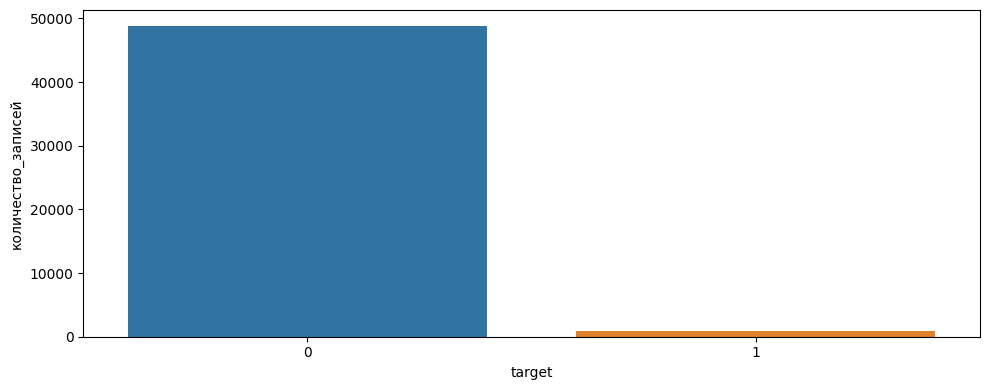

In [46]:
category_exploration(df_tar, tar_cat_cols)

Выполнено исследование состава признаков. Исключены выбросы по цене и количеству покупок.

### Подбор признаков

In [47]:
#сумма за покупку в данной категории
df_purch['sum_price'] = df_purch['quantity'] * df_purch['price']

In [48]:
df_purch.head()

,client_id,quantity,price,category_ids,date,message_id,category_0,category_1,category_2,category_3,category_4,sum_price
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,0,1999.0
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,0,2499.0
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,57,431,0,6499.0
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,244,432,0,4999.0
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,49,413,0,4999.0


In [49]:
#уровень категории для построения сводной таблицы по количеству товара 
#и сумме потраченных денег покупателем в разрезе категорий данного уровня
#можно менять для обучения моделей
cat_col = 'category_0'

In [50]:
#признак: количество купленного товара в разрезе категорий
purch_cnt_cat = df_purch.pivot_table(index='client_id', columns=cat_col, values='quantity', aggfunc='sum').reset_index()
purch_cnt_cat.columns = [cat_col + "_cnt_" + str(x) for x in purch_cnt_cat.columns]
purch_cnt_cat = purch_cnt_cat.fillna(0)

In [51]:
display(purch_cnt_cat)

,category_0_cnt_client_id,category_0_cnt_0,category_0_cnt_1,category_0_cnt_2,category_0_cnt_3,category_0_cnt_4,category_0_cnt_5,category_0_cnt_5562,category_0_cnt_5963,category_0_cnt_6060
0,1515915625468060902,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
1,1515915625468061003,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
2,1515915625468061099,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1515915625468061100,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1515915625468061170,1.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
49837,1515915626010261344,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
49838,1515915626010266132,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
49839,1515915626010439406,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
49840,1515915626010443527,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
purch_cnt_cat.columns

Index(['category_0_cnt_client_id', 'category_0_cnt_0', 'category_0_cnt_1',
       'category_0_cnt_2', 'category_0_cnt_3', 'category_0_cnt_4',
       'category_0_cnt_5', 'category_0_cnt_5562', 'category_0_cnt_5963',
       'category_0_cnt_6060'],
      dtype='object')

In [53]:
#признак: сумма потраченных денег в разрезе категорий
purch_sum_cat = df_purch.pivot_table(index='client_id', columns=cat_col, values='sum_price', aggfunc='sum').reset_index()
purch_sum_cat.columns = [cat_col + "_sum_" + str(x) for x in purch_sum_cat.columns]
purch_sum_cat = purch_sum_cat.fillna(0)

In [54]:
display(purch_sum_cat)

,category_0_sum_client_id,category_0_sum_0,category_0_sum_1,category_0_sum_2,category_0_sum_3,category_0_sum_4,category_0_sum_5,category_0_sum_5562,category_0_sum_5963,category_0_sum_6060
0,1515915625468060902,0.0,0.0,0.0,0.0,4795.0,0.0,0.0,0.0,0.0
1,1515915625468061003,0.0,0.0,0.0,0.0,14135.0,0.0,0.0,0.0,0.0
2,1515915625468061099,0.0,0.0,0.0,0.0,299.0,0.0,0.0,0.0,0.0
3,1515915625468061100,0.0,0.0,0.0,0.0,1049.0,0.0,0.0,0.0,0.0
4,1515915625468061170,7.0,0.0,2699.0,0.0,11396.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
49837,1515915626010261344,0.0,0.0,1499.0,0.0,0.0,0.0,0.0,0.0,0.0
49838,1515915626010266132,0.0,0.0,0.0,0.0,909.0,0.0,0.0,0.0,0.0
49839,1515915626010439406,0.0,0.0,0.0,0.0,99.0,0.0,0.0,0.0,0.0
49840,1515915626010443527,0.0,0.0,1999.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
purch_sum_cat.columns

Index(['category_0_sum_client_id', 'category_0_sum_0', 'category_0_sum_1',
       'category_0_sum_2', 'category_0_sum_3', 'category_0_sum_4',
       'category_0_sum_5', 'category_0_sum_5562', 'category_0_sum_5963',
       'category_0_sum_6060'],
      dtype='object')

По сводным таблицам видно, что число уникальных идентификаторов пользователей равно 49 842.

In [56]:
df_mess.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [57]:
#признак: число событий по рекламным сообщениям по каждому клитенту
mess_cnt_event = df_mess.pivot_table(index='client_id', columns='event', values='bulk_campaign_id', aggfunc='count').reset_index()
mess_cnt_event.columns = ["event_cnt_" + str(x) for x in mess_cnt_event.columns]
mess_cnt_event = mess_cnt_event.fillna(0)

In [58]:
display(mess_cnt_event)

,event_cnt_client_id,event_cnt_click,event_cnt_close,event_cnt_complain,event_cnt_hard_bounce,event_cnt_hbq_spam,event_cnt_open,event_cnt_purchase,event_cnt_send,event_cnt_soft_bounce,event_cnt_subscribe,event_cnt_unsubscribe
0,1515915625468060902,10.0,0.0,0.0,0.0,0.0,35.0,5.0,126.0,0.0,0.0,1.0
1,1515915625468061003,5.0,0.0,0.0,0.0,0.0,5.0,1.0,154.0,0.0,0.0,0.0
2,1515915625468061099,8.0,0.0,0.0,2.0,0.0,51.0,0.0,215.0,0.0,0.0,0.0
3,1515915625468061100,1.0,0.0,0.0,1.0,0.0,157.0,1.0,267.0,1.0,0.0,0.0
4,1515915625468061170,16.0,0.0,0.0,0.0,0.0,31.0,3.0,243.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
53324,1515915626010183608,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0
53325,1515915626010221592,2.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0
53326,1515915626010234726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
53327,1515915626010261344,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [59]:
#признак: число рекламных сообщений в разрезе видов
mess_cnt_channel = df_mess.pivot_table(index='client_id', columns='channel', values='bulk_campaign_id', aggfunc='count').reset_index()
mess_cnt_channel.columns = ["channel_cnt_" + str(x) for x in mess_cnt_channel.columns]
mess_cnt_channel = mess_cnt_channel.fillna(0)

In [60]:
display(mess_cnt_channel)

,channel_cnt_client_id,channel_cnt_email,channel_cnt_mobile_push
0,1515915625468060902,177.0,0.0
1,1515915625468061003,165.0,0.0
2,1515915625468061099,182.0,94.0
3,1515915625468061100,0.0,428.0
4,1515915625468061170,202.0,91.0
...,...,...,...
53324,1515915626010183608,0.0,4.0
53325,1515915626010221592,0.0,6.0
53326,1515915626010234726,0.0,1.0
53327,1515915626010261344,0.0,3.0


По сводным таблицам видно, что число уникальных идентификаторов пользователей равно 53 329. Произведем слияние таблиц по клиентам для построения общей таблицы с целевым признаком

In [61]:
_df_tar = df_tar.merge(purch_cnt_cat, left_on='client_id', right_on='category_0_cnt_client_id', how='left')

In [62]:
_df_tar = _df_tar.merge(purch_sum_cat, left_on='client_id', right_on='category_0_sum_client_id', how='left')

In [63]:
_df_tar = _df_tar.merge(mess_cnt_event, left_on='client_id', right_on='event_cnt_client_id', how='left')

In [64]:
_df_tar = _df_tar.merge(mess_cnt_channel, left_on='client_id', right_on='channel_cnt_client_id', how='left')

In [65]:
_df_tar.columns

Index(['client_id', 'target', 'category_0_cnt_client_id', 'category_0_cnt_0',
       'category_0_cnt_1', 'category_0_cnt_2', 'category_0_cnt_3',
       'category_0_cnt_4', 'category_0_cnt_5', 'category_0_cnt_5562',
       'category_0_cnt_5963', 'category_0_cnt_6060',
       'category_0_sum_client_id', 'category_0_sum_0', 'category_0_sum_1',
       'category_0_sum_2', 'category_0_sum_3', 'category_0_sum_4',
       'category_0_sum_5', 'category_0_sum_5562', 'category_0_sum_5963',
       'category_0_sum_6060', 'event_cnt_client_id', 'event_cnt_click',
       'event_cnt_close', 'event_cnt_complain', 'event_cnt_hard_bounce',
       'event_cnt_hbq_spam', 'event_cnt_open', 'event_cnt_purchase',
       'event_cnt_send', 'event_cnt_soft_bounce', 'event_cnt_subscribe',
       'event_cnt_unsubscribe', 'channel_cnt_client_id', 'channel_cnt_email',
       'channel_cnt_mobile_push'],
      dtype='object')

In [66]:
#максимальная дата покупки по каждому клиенту
purch_time = df_purch.pivot_table(index='client_id', values='date', aggfunc='max').reset_index()
purch_time.columns = [ "maxdatepur_" + str(x) for x in purch_time.columns]
purch_time = purch_time.fillna(0)

In [67]:
#максимальная дата рассылки сообщений по каждому клиенту
mess_time = df_mess.pivot_table(index='client_id', values='date', aggfunc='max').reset_index()
mess_time.columns = ["maxdateme_" + str(x) for x in mess_time.columns]
mess_time = mess_time.fillna(0)

In [68]:
diff_time = purch_time.merge(mess_time, left_on='maxdatepur_client_id', right_on='maxdateme_client_id', how='inner')

In [69]:
#признак: разница между датой последней рассылки и последней покупкой
diff_time['diff_time'] = (diff_time['maxdatepur_date'] - diff_time['maxdateme_date']).dt.days

In [70]:
display(diff_time)

,maxdatepur_client_id,maxdatepur_date,maxdateme_client_id,maxdateme_date,diff_time
0,1515915625468060902,2022-05-27,1515915625468060902,2024-01-19,-602
1,1515915625468061003,2023-01-04,1515915625468061003,2024-02-13,-405
2,1515915625468061099,2022-05-17,1515915625468061099,2024-02-13,-637
3,1515915625468061100,2024-02-10,1515915625468061100,2024-02-15,-5
4,1515915625468061170,2023-06-17,1515915625468061170,2024-02-15,-243
...,...,...,...,...,...
41971,1515915626010079153,2024-02-13,1515915626010079153,2024-02-13,0
41972,1515915626010152263,2024-02-14,1515915626010152263,2024-02-14,0
41973,1515915626010183608,2024-02-13,1515915626010183608,2024-02-15,-2
41974,1515915626010221592,2024-02-16,1515915626010221592,2024-02-15,1


In [71]:
diff_time = diff_time.drop(['maxdatepur_date', 'maxdateme_date', 'maxdateme_client_id' ], axis=1)

In [72]:
#максимальная дата покупки по всему датасету (считаем как будто - это дата выгрузки)
max_date_shop = df_purch['date'].max()

In [73]:
#признак: число дней от даты выгрузки до последней даты покупки, т.е. как давно покупал клиент
purch_time['shoptime'] = (max_date_shop - purch_time['maxdatepur_date']).dt.days

In [74]:
purch_time = purch_time.drop(['maxdatepur_date'], axis=1)

In [75]:
_df_tar = _df_tar.merge(purch_time, left_on='client_id', right_on='maxdatepur_client_id', how='left')

In [76]:
_df_tar = _df_tar.drop(['maxdatepur_client_id'], axis=1)

In [77]:
_df_tar = _df_tar.merge(diff_time, left_on='client_id', right_on='maxdatepur_client_id', how='left')

In [78]:
_df_tar.head(10)

,client_id,target,category_0_cnt_client_id,category_0_cnt_0,category_0_cnt_1,category_0_cnt_2,category_0_cnt_3,category_0_cnt_4,category_0_cnt_5,category_0_cnt_5562,...,event_cnt_send,event_cnt_soft_bounce,event_cnt_subscribe,event_cnt_unsubscribe,channel_cnt_client_id,channel_cnt_email,channel_cnt_mobile_push,shoptime,maxdatepur_client_id,diff_time
0,1515915625468060902,0,1.515916e+18,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,126.0,0.0,0.0,1.0,1.515916e+18,177.0,0.0,630.0,1.515916e+18,-602.0
1,1515915625468061003,1,1.515916e+18,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,154.0,0.0,0.0,0.0,1.515916e+18,165.0,0.0,408.0,1.515916e+18,-405.0
2,1515915625468061099,0,1.515916e+18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,215.0,0.0,0.0,0.0,1.515916e+18,182.0,94.0,640.0,1.515916e+18,-637.0
3,1515915625468061100,0,1.515916e+18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,267.0,1.0,0.0,0.0,1.515916e+18,0.0,428.0,6.0,1.515916e+18,-5.0
4,1515915625468061170,0,1.515916e+18,1.0,0.0,1.0,0.0,6.0,0.0,0.0,...,243.0,0.0,0.0,0.0,1.515916e+18,202.0,91.0,244.0,1.515916e+18,-243.0
5,1515915625468061514,0,1.515916e+18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,150.0,0.0,0.0,0.0,1.515916e+18,180.0,0.0,566.0,1.515916e+18,-563.0
6,1515915625468061877,0,1.515916e+18,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,173.0,0.0,0.0,0.0,1.515916e+18,67.0,162.0,546.0,1.515916e+18,-545.0
7,1515915625468061975,0,1.515916e+18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,154.0,0.0,0.0,0.0,1.515916e+18,180.0,0.0,569.0,1.515916e+18,-566.0
8,1515915625468061994,0,1.515916e+18,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,346.0,0.0,0.0,0.0,1.515916e+18,96.0,282.0,429.0,1.515916e+18,-427.0
9,1515915625468062158,0,1.515916e+18,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,113.0,0.0,0.0,0.0,1.515916e+18,172.0,0.0,294.0,1.515916e+18,-291.0


In [79]:
df_purch.head()

,client_id,quantity,price,category_ids,date,message_id,category_0,category_1,category_2,category_3,category_4,sum_price
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,0,1999.0
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,0,2499.0
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,57,431,0,6499.0
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,244,432,0,4999.0
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,49,413,0,4999.0


In [80]:
#признак: продолжительность покупок клиентом 
dateshop = df_purch.pivot_table(index='client_id', values='date', aggfunc=['max', 'min']).reset_index()
dateshop.columns = ['client_id', 'max_date', 'min_date']
dateshop['long_life'] = (dateshop['max_date'] - dateshop['min_date']).dt.days
dateshop = dateshop.drop(['max_date', 'min_date'], axis = 1)
dateshop.head()

,client_id,long_life
0,1515915625468060902,0
1,1515915625468061003,0
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,83


In [81]:
_df_tar = _df_tar.merge(dateshop, on='client_id', how='left')

In [82]:
#число покупок клиентом
cnt_shop = df_purch.pivot_table(index='client_id', values='date', aggfunc=lambda x: len(x.unique())).reset_index()
cnt_shop.columns = ['client_id', 'cnt_shop']

In [83]:
display(cnt_shop)

,client_id,cnt_shop
0,1515915625468060902,1
1,1515915625468061003,1
2,1515915625468061099,1
3,1515915625468061100,1
4,1515915625468061170,3
...,...,...
49837,1515915626010261344,1
49838,1515915626010266132,1
49839,1515915626010439406,1
49840,1515915626010443527,1


In [84]:
_df_tar = _df_tar.merge(cnt_shop, on='client_id', how='left')

In [85]:
display(_df_tar)

,client_id,target,category_0_cnt_client_id,category_0_cnt_0,category_0_cnt_1,category_0_cnt_2,category_0_cnt_3,category_0_cnt_4,category_0_cnt_5,category_0_cnt_5562,...,event_cnt_subscribe,event_cnt_unsubscribe,channel_cnt_client_id,channel_cnt_email,channel_cnt_mobile_push,shoptime,maxdatepur_client_id,diff_time,long_life,cnt_shop
0,1515915625468060902,0,1.515916e+18,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,1.0,1.515916e+18,177.0,0.0,630.0,1.515916e+18,-602.0,0.0,1.0
1,1515915625468061003,1,1.515916e+18,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,0.0,0.0,1.515916e+18,165.0,0.0,408.0,1.515916e+18,-405.0,0.0,1.0
2,1515915625468061099,0,1.515916e+18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.515916e+18,182.0,94.0,640.0,1.515916e+18,-637.0,0.0,1.0
3,1515915625468061100,0,1.515916e+18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.515916e+18,0.0,428.0,6.0,1.515916e+18,-5.0,0.0,1.0
4,1515915625468061170,0,1.515916e+18,1.0,0.0,1.0,0.0,6.0,0.0,0.0,...,0.0,0.0,1.515916e+18,202.0,91.0,244.0,1.515916e+18,-243.0,83.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49844,1515915626010261344,0,1.515916e+18,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.515916e+18,0.0,3.0,0.0,1.515916e+18,1.0,0.0,1.0
49845,1515915626010266132,0,1.515916e+18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,0.0,1.0
49846,1515915626010439406,0,1.515916e+18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,1.0
49847,1515915626010443527,0,1.515916e+18,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,1.0


**Выводы по 2 разделу:** В результате анализа датасетов были добавлены следующие признаки:

- сумма за покупку в разрезе категории заданного уровня;
- количество купленного товара в разрезе категорий;
- сумма потраченных клиентом денег в разрезе категорий;
- число событий по рекламным сообщениям по каждому клитенту;
- число рекламных сообщений в разрезе видов;
- число дней между датой последней рассылки и последней покупкой;
- число дней от даты выгрузки до последней даты покупки;
- продолжительность покупок клиентом;
- число покупок клиентом.

## Корреляционный анализ

In [86]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [87]:
df_target = _df_tar.drop(
    ['category_0_cnt_client_id', 'category_0_sum_client_id',
     'event_cnt_client_id', 'channel_cnt_client_id',
     'maxdatepur_client_id'], axis=1
)

In [88]:
df_target.head()

,client_id,target,category_0_cnt_0,category_0_cnt_1,category_0_cnt_2,category_0_cnt_3,category_0_cnt_4,category_0_cnt_5,category_0_cnt_5562,category_0_cnt_5963,category_0_cnt_6060,category_0_sum_0,category_0_sum_1,category_0_sum_2,category_0_sum_3,category_0_sum_4,category_0_sum_5,category_0_sum_5562,category_0_sum_5963,category_0_sum_6060,event_cnt_click,event_cnt_close,event_cnt_complain,event_cnt_hard_bounce,event_cnt_hbq_spam,event_cnt_open,event_cnt_purchase,event_cnt_send,event_cnt_soft_bounce,event_cnt_subscribe,event_cnt_unsubscribe,channel_cnt_email,channel_cnt_mobile_push,shoptime,diff_time,long_life,cnt_shop
0,1515915625468060902,0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4795.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,35.0,5.0,126.0,0.0,0.0,1.0,177.0,0.0,630.0,-602.0,0.0,1.0
1,1515915625468061003,1,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14135.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,1.0,154.0,0.0,0.0,0.0,165.0,0.0,408.0,-405.0,0.0,1.0
2,1515915625468061099,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,299.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,2.0,0.0,51.0,0.0,215.0,0.0,0.0,0.0,182.0,94.0,640.0,-637.0,0.0,1.0
3,1515915625468061100,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1049.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,157.0,1.0,267.0,1.0,0.0,0.0,0.0,428.0,6.0,-5.0,0.0,1.0
4,1515915625468061170,0,1.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0,7.0,0.0,2699.0,0.0,11396.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,31.0,3.0,243.0,0.0,0.0,0.0,202.0,91.0,244.0,-243.0,83.0,3.0


interval columns not set, guessing: ['client_id', 'target', 'category_0_cnt_0', 'category_0_cnt_1', 'category_0_cnt_2', 'category_0_cnt_3', 'category_0_cnt_4', 'category_0_cnt_5', 'category_0_cnt_5562', 'category_0_cnt_5963', 'category_0_cnt_6060', 'category_0_sum_0', 'category_0_sum_1', 'category_0_sum_2', 'category_0_sum_3', 'category_0_sum_4', 'category_0_sum_5', 'category_0_sum_5562', 'category_0_sum_5963', 'category_0_sum_6060', 'event_cnt_click', 'event_cnt_close', 'event_cnt_complain', 'event_cnt_hard_bounce', 'event_cnt_hbq_spam', 'event_cnt_open', 'event_cnt_purchase', 'event_cnt_send', 'event_cnt_soft_bounce', 'event_cnt_subscribe', 'event_cnt_unsubscribe', 'channel_cnt_email', 'channel_cnt_mobile_push', 'shoptime', 'diff_time', 'long_life', 'cnt_shop']


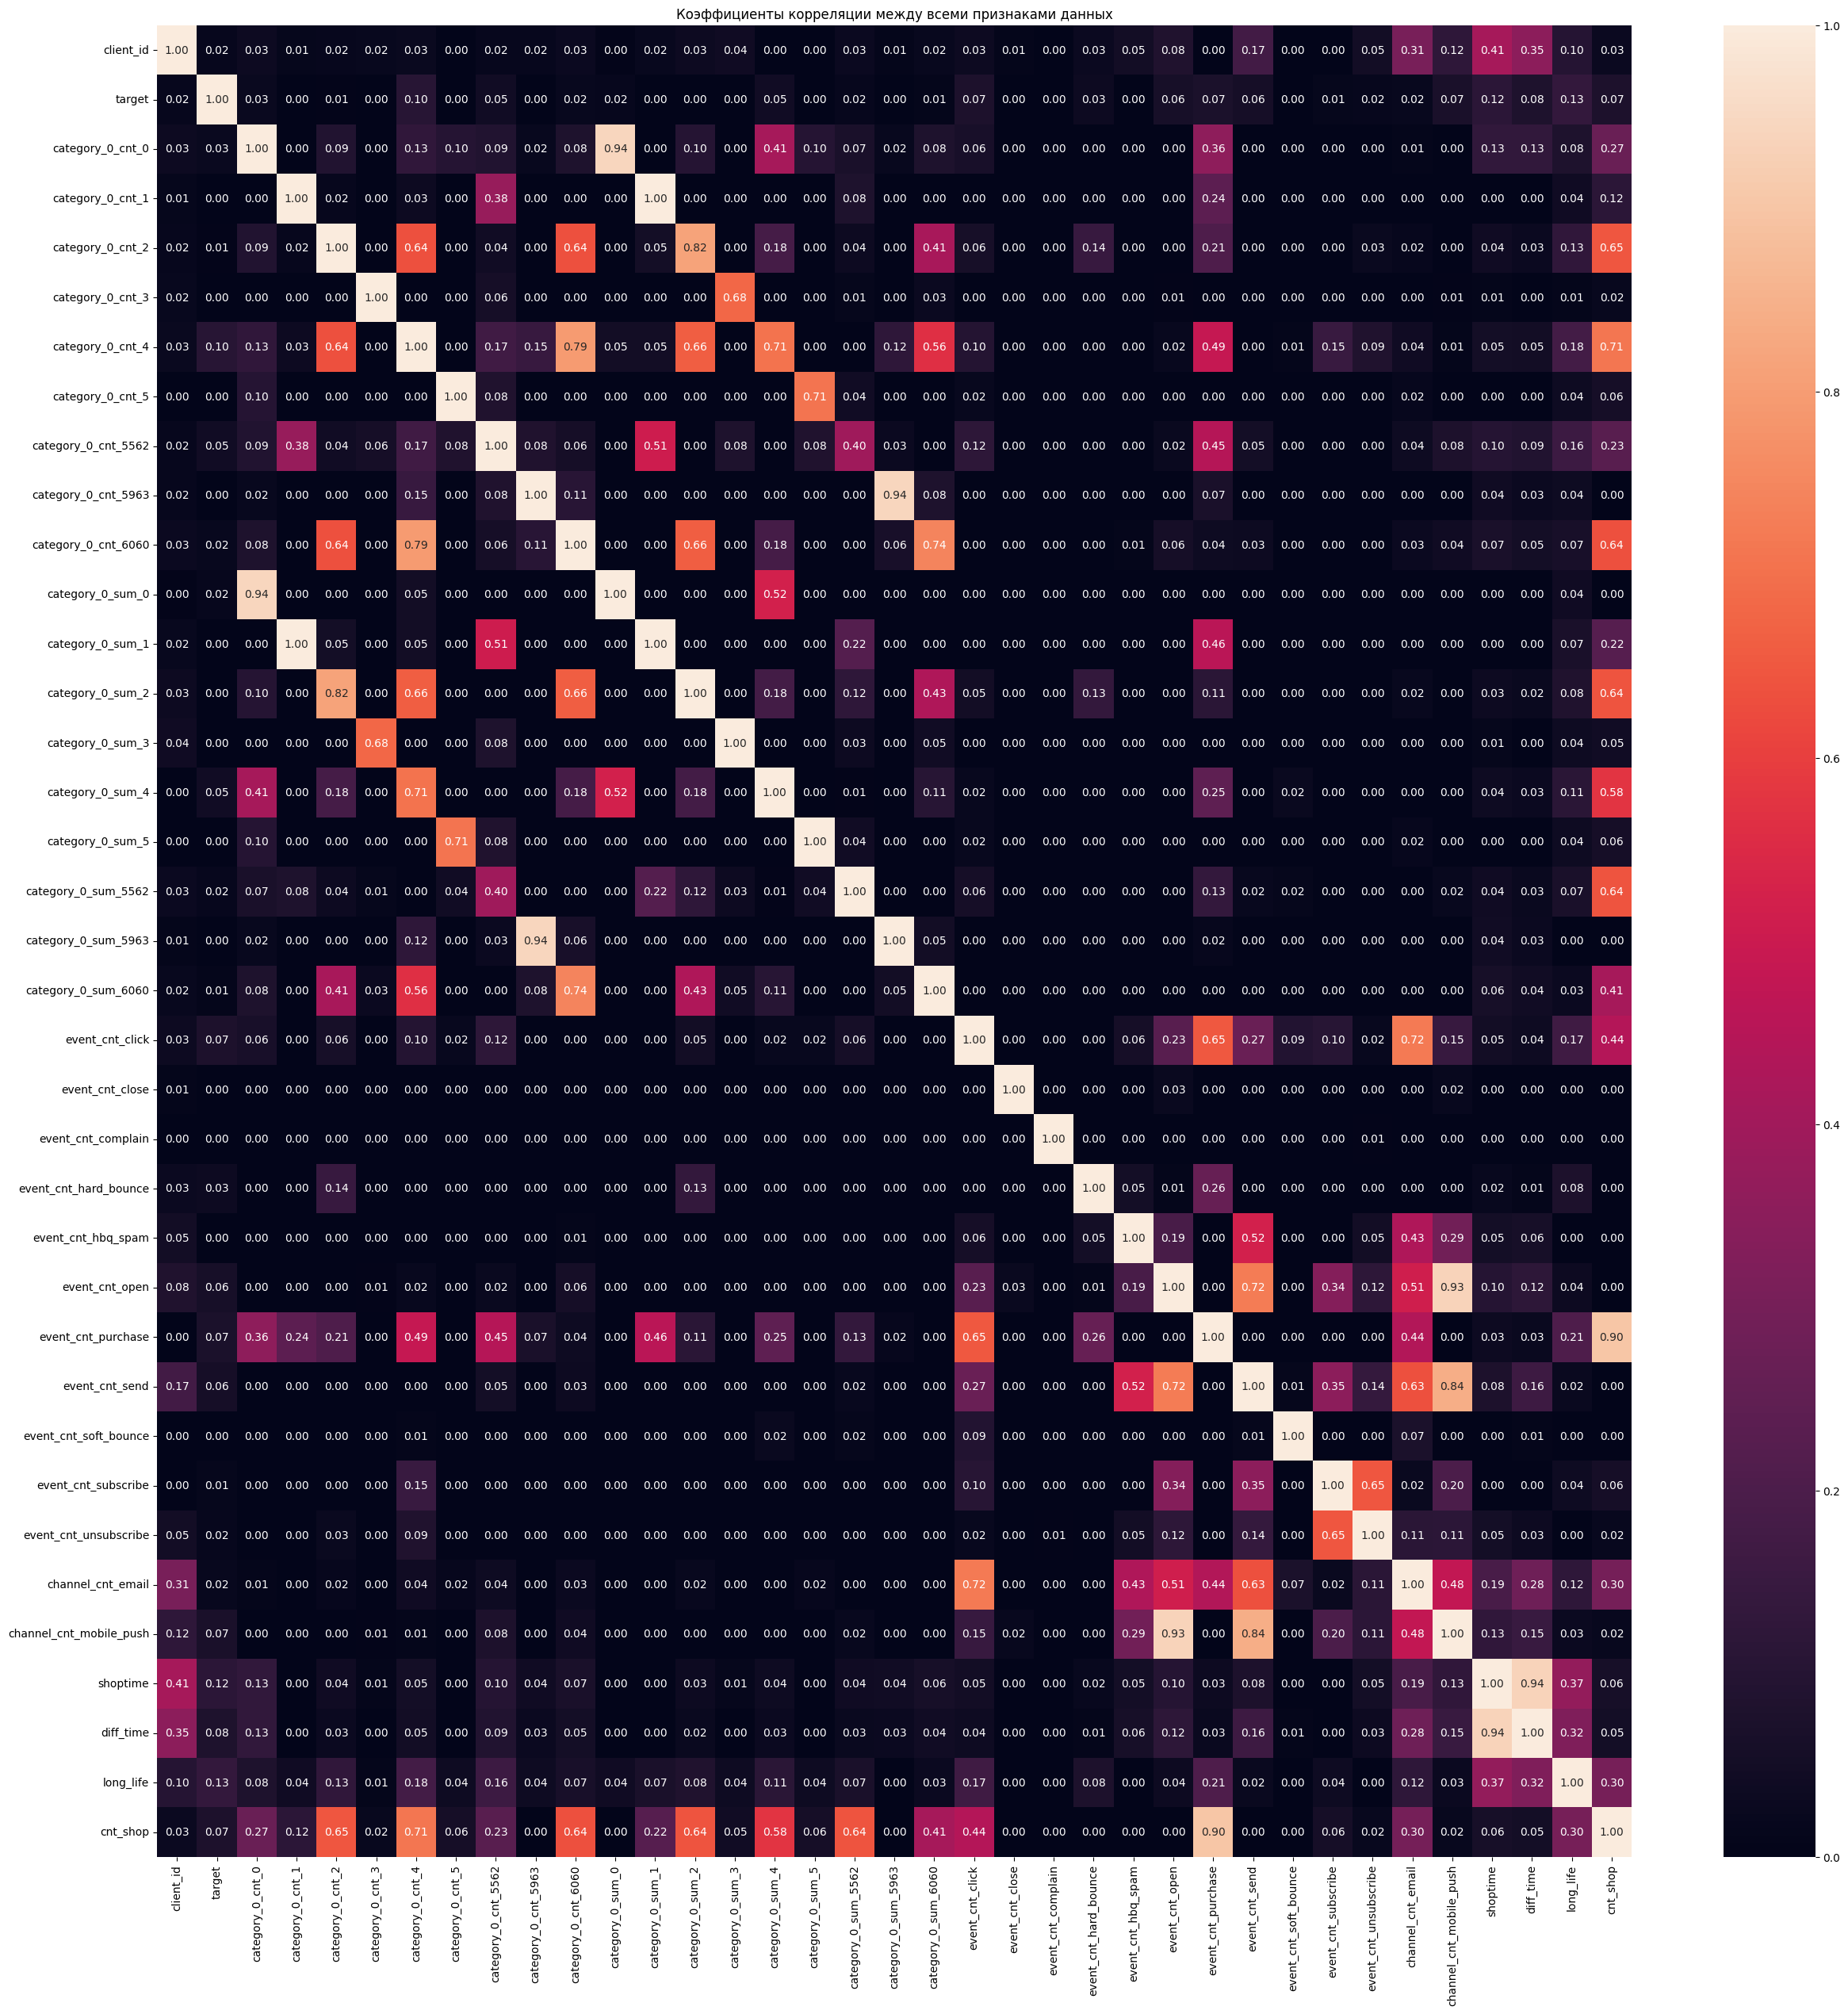

In [89]:
_phik_matrix = df_target.phik_matrix()
plt.figure(figsize=(30, 30))
sns.heatmap(_phik_matrix, annot=True, fmt=".2f");
plt.title('Коэффициенты корреляции между всеми признаками данных');

In [90]:
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

**Выводы по 3 разделу:** В результате корреляционного анализа установлено:

- влияние на целевой признак: число дней от даты выгрузки до последней даты покупки, продолжительность покупок покупателем;
- установлена высокая корреляция между признаками: число дней от даты выгрузки до последней даты покупки, продолжительность покупок покупателем;
- есть нулевая корреляция между целевым признаком и числом, суммой покупок по отдельными категориям, а также между целевым признаком и отдельными событиями пользователей на рекламные сообщения.

## Подготовка данных для обучения

Перед подготовкой данных, проведем их оптимизацию.

In [91]:
df_target = optimize_memory_usage(df_target, True)

Размер использования памяти: до 14.07 Mb - после  7.08 Mb (49.7%)


In [92]:
target = 'target'
exclude = ['category_3_cnt_8', 'category_3_cnt_10', 'category_3_cnt_12', 'category_3_cnt_14', 'category_3_cnt_22',
           'category_1_sum_8', 'category_1_sum_10', 'category_1_sum_12', 'category_1_sum_14', 'category_1_sum_22', 
           'event_cnt_close']

In [93]:
X = df_target.drop(['client_id', 'target'], axis = 1)

In [94]:
data_info(X,'Данные для моделей')

Информация о столбцах таблицы  Данные для моделей
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   category_0_cnt_0         49842 non-null  float32
 1   category_0_cnt_1         49842 non-null  float32
 2   category_0_cnt_2         49842 non-null  float32
 3   category_0_cnt_3         49842 non-null  float32
 4   category_0_cnt_4         49842 non-null  float32
 5   category_0_cnt_5         49842 non-null  float32
 6   category_0_cnt_5562      49842 non-null  float32
 7   category_0_cnt_5963      49842 non-null  float32
 8   category_0_cnt_6060      49842 non-null  float32
 9   category_0_sum_0         49842 non-null  float32
 10  category_0_sum_1         49842 non-null  float32
 11  category_0_sum_2         49842 non-null  float32
 12  category_0_sum_3         49842 non-null  float32
 13  category_0_sum_4         4

None

Количество незаполненных значений в полях:
category_0_cnt_0              7
category_0_cnt_1              7
category_0_cnt_2              7
category_0_cnt_3              7
category_0_cnt_4              7
category_0_cnt_5              7
category_0_cnt_5562           7
category_0_cnt_5963           7
category_0_cnt_6060           7
category_0_sum_0              7
category_0_sum_1              7
category_0_sum_2              7
category_0_sum_3              7
category_0_sum_4              7
category_0_sum_5              7
category_0_sum_5562           7
category_0_sum_5963           7
category_0_sum_6060           7
event_cnt_click            7867
event_cnt_close            7867
event_cnt_complain         7867
event_cnt_hard_bounce      7867
event_cnt_hbq_spam         7867
event_cnt_open             7867
event_cnt_purchase         7867
event_cnt_send             7867
event_cnt_soft_bounce      7867
event_cnt_subscribe        7867
event_cnt_unsubscribe      7867
channel_cnt_email          78

In [95]:
df_target = df_target[~X.duplicated()]

In [96]:
X = df_target.drop([target], axis = 1)
y = df_target[target]

In [97]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify=y
)

In [98]:
X_train, X_test = make_rating(df_purch, X_train, X_test)

In [99]:
X_train = X_train.drop(['client_id'], axis = 1)

In [100]:
X_test = X_test.drop(['client_id'], axis = 1)

**Выводы по 4 разделу:** Выполнено разделение выборки на тренировочную и тестовую. Также введен новый признак - наиболее часто покупаемая категория товара последней покупки. Частота (рейтинг) покупок определена на тренировочной выборке.

## Анализ моделей

In [101]:
df_res = pd.DataFrame(columns=['best_estimator', 'model', 'roc_auc', 'mean_fit_time', 'mean_score_time'])

### Обучение деревьев решений

In [102]:
# создаём пайплайн для подготовки признаков
num_pipe_int = Pipeline(
    [
     ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='constant')),
     ('ch_cat',FunctionTransformer(change_type_int) )
    ]
    )
num_pipe_int.set_output(transform="pandas")

Pipeline(steps=[('simpleImputer_num', SimpleImputer(strategy='constant')),
                ('ch_cat',
                 FunctionTransformer(func=<function change_type_int at 0x0000014D31EF1F80>))])

In [103]:
# создаем итоговый пайплайн: подготовка данных и модель
pipe_final_tree = Pipeline(
    [
        ('preprocessor', num_pipe_int),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE, \
        max_depth = 5, max_features = 5, class_weight='balanced'))
    ]
)
param_grid_tree = [
     # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [5,10,15,20,25],
        'models__max_features': [5,10,15,20,25,30,40],
        'models__min_samples_leaf': [5,7,10]
    }    
]

In [104]:
res_tree = best_among_class_model(pipe_final_tree, param_grid_tree, X_train, y_train)

In [105]:
df_res.loc[ len(df_res.index )] = res_tree

### Обучение модели LightGBM

In [106]:
# создаём пайплайн для подготовки признаков
num_pipe_cat = Pipeline(
    [
     ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='constant')),
     ('ch_cat',FunctionTransformer(change_type_cat) )
    ]
    )
num_pipe_cat.set_output(transform="pandas")

Pipeline(steps=[('simpleImputer_num', SimpleImputer(strategy='constant')),
                ('ch_cat',
                 FunctionTransformer(func=<function change_type_cat at 0x0000014D31EF2160>))])

In [107]:
# создаем итоговый пайплайн: подготовка данных и модель
pipe_final_gbm = Pipeline(
    [
        ('preprocessor', num_pipe_cat),
        ('models',LGBMClassifier(random_state=RANDOM_STATE, is_unbalance=True))
    ]
)
param_grid_gbm = [
  
     # словарь для модели LGBMClassifier() 
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE, is_unbalance=True)], 
        'models__max_depth': np.arange(8,16,2),
        'models__num_leaves': np.arange(10,20,2),
        'models__n_estimators': [8,10,16,24,30,32,40,48]
    }   
    
]

In [108]:
res_gbm = best_among_class_model(pipe_final_gbm, param_grid_gbm, X_train, y_train)

[LightGBM] [Info] Number of positive: 768, number of negative: 38741
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3562
[LightGBM] [Info] Number of data points in the train set: 39509, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019439 -> initscore=-3.920864
[LightGBM] [Info] Start training from score -3.920864


In [109]:
df_res.loc[ len(df_res.index )] = res_gbm

### Обучение модели CatBoost

In [110]:
# создаём пайплайн для подготовки признаков
num_pipe_obj = Pipeline(
    [
     ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='constant')),
     ('ch_cat',FunctionTransformer(change_type_obj) )
    ]
    )
num_pipe_obj.set_output(transform="pandas")

Pipeline(steps=[('simpleImputer_num', SimpleImputer(strategy='constant')),
                ('ch_cat',
                 FunctionTransformer(func=<function change_type_obj at 0x0000014D31EF2D40>))])

In [111]:
# создаем итоговый пайплайн: подготовка данных и модель
pipe_final_cat = Pipeline(
    [
        ('preprocessor', num_pipe_obj),
        ('models', CatBoostClassifier(random_state=RANDOM_STATE, auto_class_weights='Balanced', iterations=200))
    ]
)
param_grid_cat = [
   
    {'models': [CatBoostClassifier(random_state=RANDOM_STATE, auto_class_weights='Balanced', iterations=200)],
     'models__depth': [6, 10],
     'models__learning_rate': [0.01, 0.1]
    }
    
    
]

In [112]:
res_cat = best_among_class_model(pipe_final_cat, param_grid_cat, X_train, y_train)

0:	learn: 0.6916486	total: 163ms	remaining: 32.4s
1:	learn: 0.6898408	total: 204ms	remaining: 20.2s
2:	learn: 0.6881935	total: 246ms	remaining: 16.2s
3:	learn: 0.6861311	total: 286ms	remaining: 14s
4:	learn: 0.6845427	total: 323ms	remaining: 12.6s
5:	learn: 0.6825985	total: 355ms	remaining: 11.5s
6:	learn: 0.6810703	total: 394ms	remaining: 10.9s
7:	learn: 0.6795342	total: 434ms	remaining: 10.4s
8:	learn: 0.6779229	total: 474ms	remaining: 10.1s
9:	learn: 0.6766494	total: 510ms	remaining: 9.69s
10:	learn: 0.6751827	total: 541ms	remaining: 9.3s
11:	learn: 0.6735436	total: 575ms	remaining: 9.01s
12:	learn: 0.6723081	total: 620ms	remaining: 8.91s
13:	learn: 0.6710051	total: 658ms	remaining: 8.74s
14:	learn: 0.6696824	total: 694ms	remaining: 8.56s
15:	learn: 0.6683263	total: 729ms	remaining: 8.38s
16:	learn: 0.6669352	total: 756ms	remaining: 8.14s
17:	learn: 0.6657128	total: 789ms	remaining: 7.98s
18:	learn: 0.6643954	total: 827ms	remaining: 7.88s
19:	learn: 0.6632207	total: 863ms	remaining:

166:	learn: 0.5820286	total: 6.15s	remaining: 1.22s
167:	learn: 0.5818047	total: 6.19s	remaining: 1.18s
168:	learn: 0.5814427	total: 6.23s	remaining: 1.14s
169:	learn: 0.5813319	total: 6.27s	remaining: 1.11s
170:	learn: 0.5811457	total: 6.3s	remaining: 1.07s
171:	learn: 0.5808418	total: 6.35s	remaining: 1.03s
172:	learn: 0.5806799	total: 6.4s	remaining: 999ms
173:	learn: 0.5805348	total: 6.45s	remaining: 963ms
174:	learn: 0.5803214	total: 6.49s	remaining: 927ms
175:	learn: 0.5801234	total: 6.53s	remaining: 891ms
176:	learn: 0.5799675	total: 6.57s	remaining: 854ms
177:	learn: 0.5797861	total: 6.6s	remaining: 816ms
178:	learn: 0.5795882	total: 6.63s	remaining: 778ms
179:	learn: 0.5793588	total: 6.67s	remaining: 741ms
180:	learn: 0.5792313	total: 6.7s	remaining: 703ms
181:	learn: 0.5790156	total: 6.73s	remaining: 666ms
182:	learn: 0.5787868	total: 6.76s	remaining: 628ms
183:	learn: 0.5785774	total: 6.79s	remaining: 591ms
184:	learn: 0.5783389	total: 6.83s	remaining: 554ms
185:	learn: 0.57

In [113]:
df_res.loc[len(df_res.index )] = res_cat

In [114]:
df_res = present_result(df_res, X_test, y_test)
display(df_res)

Результаты лучших моделей:


,best_estimator,model,roc_auc,mean_fit_time,mean_score_time
0,"((SimpleImputer(strategy='constant'), Function...",<catboost.core.CatBoostClassifier object at 0x...,0.746617,39.769113,0.110561
1,"((SimpleImputer(strategy='constant'), Function...","LGBMClassifier(is_unbalance=True, max_depth=8,...",0.709135,1.588837,0.062432
2,"((SimpleImputer(strategy='constant'), Function...","DecisionTreeClassifier(max_depth=5, max_featur...",0.694041,0.396526,0.045733


Лучшая модель из лучших:


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('simpleImputer_num',
                                  SimpleImputer(strategy='constant')),
                                 ('ch_cat',
                                  FunctionTransformer(func=<function change_type_obj at 0x0000014D31EF2D40>))])),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x0000014D87C24A90>)])

Метрика Roc_auc на тестовой выборке для самой лучшей модели: 0.6330786702457155


,best_estimator,model,roc_auc,mean_fit_time,mean_score_time
0,"((SimpleImputer(strategy='constant'), Function...",<catboost.core.CatBoostClassifier object at 0x...,0.746617,39.769113,0.110561
1,"((SimpleImputer(strategy='constant'), Function...","LGBMClassifier(is_unbalance=True, max_depth=8,...",0.709135,1.588837,0.062432
2,"((SimpleImputer(strategy='constant'), Function...","DecisionTreeClassifier(max_depth=5, max_featur...",0.694041,0.396526,0.045733


**Выводы по 5 разделу:** Выполнено обучение трех моделей: деревьев решений, моделей градиентного бустинга LightGBM, CatBoost. Лучшей оказалась CatBoost.

## Анализ признаков

In [115]:
best_pl = df_res.loc[0,'best_estimator']
#best_pl = grid
X_test_scalled = pd.DataFrame(best_pl.named_steps['preprocessor'].transform(X_test))
X_train_scalled = pd.DataFrame(best_pl.named_steps['preprocessor'].transform(X_train))
best_model = df_res.loc[0,'model']
print(best_model)

In [116]:
X_test_scalled.columns = [ x[0:50] for x in X_train.columns]
X_train_scalled.columns = X_test_scalled.columns
X_test_scalled.columns

Index(['category_0_cnt_0', 'category_0_cnt_1', 'category_0_cnt_2',
       'category_0_cnt_3', 'category_0_cnt_4', 'category_0_cnt_5',
       'category_0_cnt_5562', 'category_0_cnt_5963', 'category_0_cnt_6060',
       'category_0_sum_0', 'category_0_sum_1', 'category_0_sum_2',
       'category_0_sum_3', 'category_0_sum_4', 'category_0_sum_5',
       'category_0_sum_5562', 'category_0_sum_5963', 'category_0_sum_6060',
       'event_cnt_click', 'event_cnt_close', 'event_cnt_complain',
       'event_cnt_hard_bounce', 'event_cnt_hbq_spam', 'event_cnt_open',
       'event_cnt_purchase', 'event_cnt_send', 'event_cnt_soft_bounce',
       'event_cnt_subscribe', 'event_cnt_unsubscribe', 'channel_cnt_email',
       'channel_cnt_mobile_push', 'shoptime', 'diff_time', 'long_life',
       'cnt_shop', 'rating'],
      dtype='object')

In [117]:
feature_importance = best_model.get_feature_importance()
feature_names = X_train_scalled.columns
feature_zip = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)

# Display feature importance
for name, importance in feature_zip:
    print(f"Feature: {name}, Importance: {importance:.2f}")

Feature: shoptime, Importance: 23.66
Feature: event_cnt_click, Importance: 13.49
Feature: long_life, Importance: 10.48
Feature: cnt_shop, Importance: 8.41
Feature: event_cnt_open, Importance: 7.56
Feature: channel_cnt_mobile_push, Importance: 7.45
Feature: diff_time, Importance: 5.37
Feature: event_cnt_unsubscribe, Importance: 3.09
Feature: category_0_sum_5562, Importance: 3.08
Feature: channel_cnt_email, Importance: 2.52
Feature: event_cnt_send, Importance: 2.01
Feature: category_0_cnt_4, Importance: 1.94
Feature: category_0_sum_4, Importance: 1.78
Feature: event_cnt_purchase, Importance: 1.72
Feature: category_0_sum_2, Importance: 1.43
Feature: rating, Importance: 1.06
Feature: category_0_sum_6060, Importance: 1.00
Feature: category_0_cnt_5562, Importance: 0.67
Feature: category_0_sum_5963, Importance: 0.55
Feature: category_0_sum_0, Importance: 0.51
Feature: category_0_cnt_2, Importance: 0.50
Feature: event_cnt_hard_bounce, Importance: 0.42
Feature: event_cnt_hbq_spam, Importance: 0

In [118]:
feature_names, feature_importance = zip(*feature_zip)
feature_importance= list(feature_importance)
feature_names= list(feature_names)

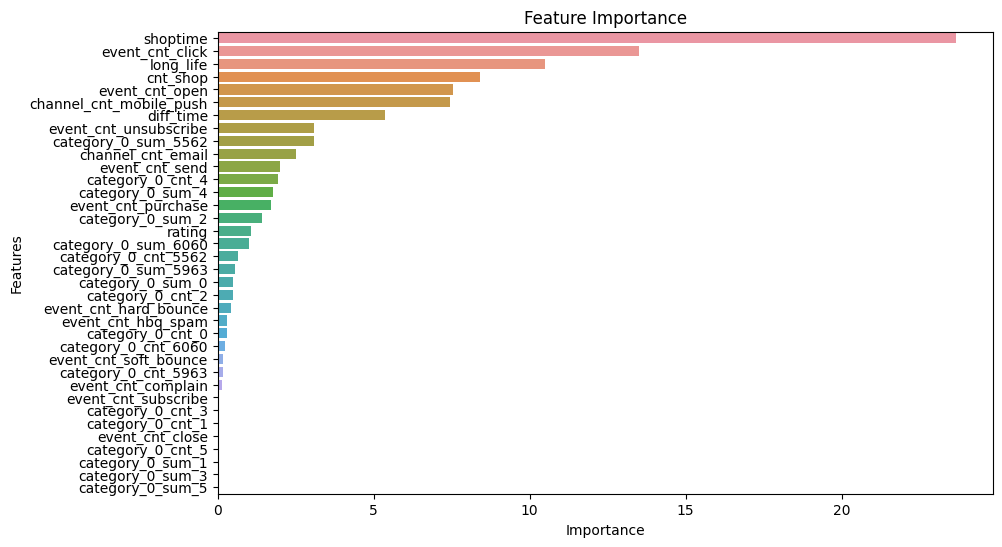

In [119]:
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_names)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [120]:
f = lambda x: best_model.predict_proba(x)[:,1]
med = X_train_scalled.median().values.reshape((1,X_train_scalled.shape[1]))
explainer = shap.KernelExplainer(f, med)
shap_values_norm = explainer.shap_values(X_test_scalled.iloc[0:1000,:], nsamples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

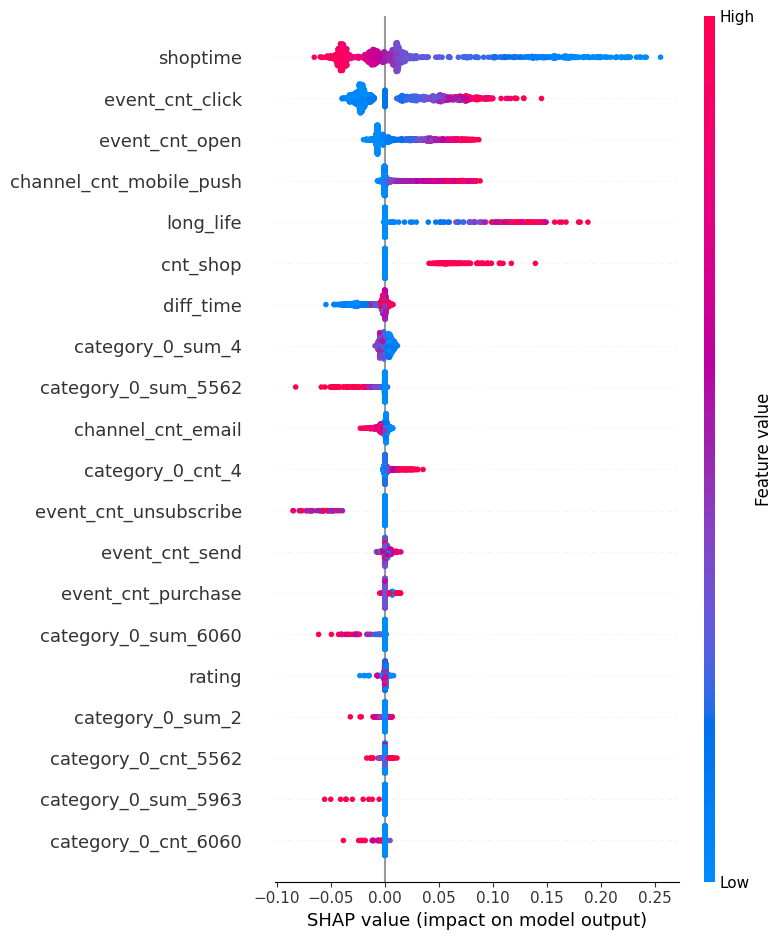

In [121]:
shap.summary_plot(shap_values_norm, X_test_scalled.iloc[0:1000,:], feature_names=X_train_scalled.columns)

In [ ]:
shap_values = explainer(X_test_scalled.iloc[0:1000,:])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
shap.summary_plot(shap_values_norm, X_test_scalled.iloc[0:1000,:], plot_type='bar', \
                  feature_names=X_train_scalled.columns, title = "SHAP Value Summary", max_display=20)

**Выводы по 6 разделу:** Исходя из анализа признаков лучшими оказались 20шт. Основные выводы исходя из анализа:

- Чем большее число дней прошло с момента последней покупки, тем меньше вероятность новой покупки этим же покупателем;
- Чем больше событий открытия и клика, а также больше пуш уведомлений через мобильный телефон, тем больше вероятность нвоой покупки;
- Чем больше разница между временем рассылки сообщений и последней покупкой, тем меньше вероятность новой покупки;
- Чем больше покупок покупатель делает, а также чем дольше он покупает через интернет магазин, тем больше вероятность новой покупки;
- Чем больше покупок в категории 4, тем большая вероятность новой покупки;
- Если покупатель откзаывается от подписки, то вероятнее он не будет более делать покупок.

## Общий вывод

Загружены данные об истории покупателей, истории рекламных рассылок и целевого признака.
Выполнена предобработка данных: установлены соответствующие типы данных, удалены дубликаты, значение категорий разбито на 4 отдельных столбца
В результате анализа датасетов были добавлены следующие признаки:

- сумма за покупку в разрезе категории заданного уровня;
- количество купленного товара в разрезе категорий;
- сумма потраченных клиентом денег в разрезе категорий;
- число событий по рекламным сообщениям по каждому клитенту;
- число рекламных сообщений в разрезе видов;
- число дней между датой последней рассылки и последней покупкой;
- число дней от даты выгрузки до последней даты покупки;
- продолжительность покупок клиентом;
- число покупок клиентом;
- наиболее часто покупаемая категория товара последней покупки. Частота (рейтинг) покупок определена на тренировочной выборке.

В результате корреляционного анализа установлено:
- влияние на целевой признак: число дней от даты выгрузки до последней даты покупки, продолжительность покупок покупателем;
- установлена высокая корреляция между признаками: число дней от даты выгрузки до последней даты покупки, продолжительность покупок покупателем;
- есть нулевая корреляция между целевым признаком и числом, суммой покупок по отдельными категориям, а также между целевым признаком и отдельными событиями пользователей на рекламные сообщения.

Выполнено обучение трех моделей: деревьев решений, моделей градиентного бустинга LightGBM, CatBoost. Лучшей оказалась CatBoost. Исходя из анализа признаков лучшими оказались 20 признаков. Основные выводы исходя из анализа:
- Чем большее число дней прошло с момента последней покупки, тем меньше вероятность новой покупки этим же покупателем;
- Чем больше событий открытия и клика, а также больше пуш уведомлений через мобильный телефон, тем больше вероятность нвоой покупки
- Чем больше разница между временем рассылки сообщений и последней покупкой, тем меньше вероятность новой покупки;
- Чем больше покупок покупатель делает, а также чем дольше он покупает через интернет магазин, тем больше вероятность новой покупки;
- Чем больше покупок в категории 4, тем большая вероятность новой покупки;
- Если покупатель откзаывается от подписки, то вероятнее он не будет более делать покупок.